# **Smart-UJ UAQUE**
Este Notebook hace parte del servicio inteligente "perfil grupal" y tiene como objetivo la generación de clusters de usuarios a partir de el alquiler de ítems de la biblioteca Alfonso Borrero Cabal. Previamente se estrajeron los temas de cada ítem y en este notebook se generarán matrices dispersas que serán consumidad por el algoritmo de k-means para generar los clusters que posteriormente serán consumidos por los diferentes algoritmo de recomendación.

**Entrada**: Tabla_join.json

**Integrantes:**</br>
Johan Ortegón </br>
Juan Angarita </br>
Jorge Salgado </br>
Daniel Tibaquira </br></br>
**Directora de Proyecto de Grado:** </br>
Viky Arias </br>

# Importación de datos

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Estas son las librerias que vamos a usar para hacer el join de ambas tablas y poder hacer las diferentes agrupaciones de estudiantes. 

* pandas(pd): Permite almacenar los datos en dataframes(matrices) y operación entre las celdas.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

Importamos el archivo. Este proviene del join entre las tablas de material bibliográfico de la biblioteca y la información de prestamos de la biblioteca. 

In [2]:
df = pd.read_json('./TABLA_JOIN.json')

In [ ]:
df.head(3)

,RowID,Mes,Fecha,IDItem,NumeroUbicacion,Dewey,Ubicacion,TipoItem_x,Llave_x,Perfil,Programa,Facultad,IDUsario,Year,Signatura,UbicacionActual,TipoItem_y,TotalPrestamos,Llave_y,Copias,Autor,Titulo,Tema650,AnioPublicación,NO_DEWEY,ENCABEZAMIENTO,original,Temas,union
0,Row0,Enero,1546992000000,80000005327627,720.98 A71S,720,COL-GRAL-2,LIBRO,866245,A-EGRESADO,CARRERA DE ARQUITECTURA,arquitectura y diseño,c361c772cd0220bb16dcfb2ad803e4903334ab94,2019,720.98,COL-GRAL-2,LIBRO,33,866245,1,"Arango Cardinal, Silvia 1948-",Ciudad y arquitectura seis generaciones que co...,arquitectura historia america latina,2012.0,720.98,Arquitectura latinoamericana,arquitectura historia america latina,"[arquitectur, histori, amer, latin]",arquitectur histori amer latin
1,Row1,Enero,1546992000000,80000001191496,720.9861 A71,720,COL-GRAL-2,LIBRO,309945,A-EGRESADO,CARRERA DE ARQUITECTURA,arquitectura y diseño,c361c772cd0220bb16dcfb2ad803e4903334ab94,2019,720.9861,COL-GRAL-2,LIBRO,367,309945,2,"Arango Cardinal, Silvia 1948-",Historia de la arquitectura en Colombia Silvia...,arquitectura colonial historia colombia,1993.0,720.9861,Arquitectura colombiana,arquitectura colonial historia colombia,"[arquitectur, colonial, histori, colombi]",arquitectur colonial histori colombi
2,Row2,Enero,1547078400000,80000004979759,540 CH15Q 2010,540,COL-GRAL-3,LIBRO,822727,A-EGRESADO,CARRERA DE ARQUITECTURA,arquitectura y diseño,87b0e5a61ed712ddfaf5d478ad68c87c825997e9,2019,540,PRESTADO,LIBRO,330,822727,2,"Chang, Raymond",Química Raymond Chang ; revisión técnica Rosa ...,quimica,2010.0,540,Química,quimica,[quimic],quimic


Anotamos la estructura del archivo. 

In [3]:
print("Numero de filas:", df.shape[0])
print("Numero de columnas:", df.shape[1])

Numero de filas: 516850
Numero de columnas: 29


El clustering para este experimento se realizará sobre el "union". No todas las columnas tienen este dato. En caso del que dato falta aparece la palabra "desconoc".

In [4]:
eliminar = df.loc[df["union"]=="desconoc"]
print("Numero de datos sin temas:" , df.loc[df["union"]=="desconoc"].shape[0])
df = df[~df.index.isin(eliminar.index)]

Numero de datos sin temas: 14075


Actualmente la tabla representa todos los prestamos. Agruparemos por usuarios y se realizará un append de los strings que están en la columna "union". 

In [5]:
grouped = df.groupby("IDUsario").agg({'union': lambda x: ' '.join(x)})

In [13]:
len(list(grouped.index))

25091

Realizamos un proceso para generar una matriz dispersa a partir de la columnas union. Esto equivale a realizar una operación de bag of words para cada usuario.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [20]:
vectorizador1 = CountVectorizer(analyzer = "word" )
# Acá está la documentación https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer
matrizCountVectorizer = vectorizador1.fit_transform(grouped['union'])
type(matrizCountVectorizer)

# Ahora veremos el resultado generando un dataframe a partir del conteo
count_array = matrizCountVectorizer.toarray()
dfCount = pd.DataFrame(data = count_array, columns = vectorizador1.get_feature_names())
final = dfCount
display(final.head(100))
print(final.shape)

,aac,aafric,aalgebr,aandin,aar,abandon,abastec,abdom,abej,abelian,...,zombis,zombism,zon,zoolog,zoologi,zoonosis,zootecni,zorr,zost,zuli
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(25091, 5593)


# Configuración Modelos
A partir del archivo "Comparación modelos" se puede concluir que el modelo que ayuda en mayor medida a agrupar los datos, minimizando el número de clusters con tamaño menor a 20 y la desviación estandar es kmeans con los siguiente parámetros:
* Filas normalizadas = true
* Columnas normalizadas = true
* PCA = 0.95
* Número de clusters = 150
* Número de iteraciones = 500

In [21]:
resumen = pd.DataFrame(columns = ["Tecnica","PCA", "Norm_filas", "Norm_col", "Precision", "Desviacion_estandar", "Media", "Coeficiente_variacion", "Clusters","Grupo_mas_grande", "Grupos<10", "Grupos<20"])


In [22]:
def std_dev_cluster(data, labs):
    sizes_labels = []
    for label in np.unique(labs):
        sizes_labels.append(len(data.loc[data["cluster"] == label]))
    
    return np.std(sizes_labels)

In [23]:
def mean_cluster(data, labs):
    sizes_labels = []
    for label in np.unique(labs):
        sizes_labels.append(len(data.loc[data["cluster"] == label]))
    
    return np.mean(sizes_labels)

In [24]:
#
PCA = 0.95
num_clusters = 150
num_iter = 3

# Algoritmo kmeans

silhouette_score:  0.03336792558760567


<AxesSubplot:>

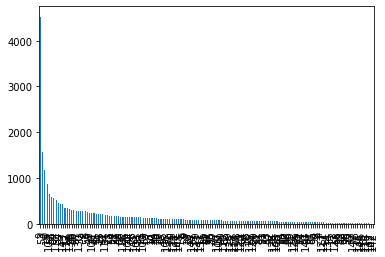

In [25]:
##Exportamos los datos del modelo que nos dio mejores resultados
#Normalización
sumatoria = final.sum(axis=1)
pesos_norm = final.div(sumatoria, axis=0).fillna(0)

scaler = MinMaxScaler()
pesos_norm = scaler.fit_transform(pesos_norm.values)

  #Kmeans
k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = num_iter)
k_means.fit_predict(pesos_norm)
labels = k_means.labels_

  #Desempeño
pres = silhouette_score(pesos_norm, labels)
print("silhouette_score: ", pres)

  #copiamos el dataframe y agregamos los clusters para gráficar la distribución
df2 = final.copy()
df2["cluster"] = labels
df2.groupby("cluster")["cluster"].count()
display(df2["cluster"].value_counts().plot(kind='bar'))

  #Cálculo de métricas
media = mean_cluster(df2,labels)
desviacion = std_dev_cluster(df2,labels)
data = df2.groupby('cluster')['union'].count()
peque10 = len(data[data<=10])
peque20 = len(data[data<=20])
masGrande = data.max()
#Agregamos los datos a nuestra tabla de resumen para comparar
resumen = resumen.append({'Tecnica':"K-MEANS",
                              'PCA':0.95,
                              'Norm_filas':True,
                              'Norm_col':True,
                              'Precision':pres,
                              'Desviacion_estandar':desviacion,
                              'Media':media,
                              'Coeficiente_variacion':desviacion/media, 
                              'Clusters': num_clusters,
                              "Grupos<20":peque20,
                              "Grupos<10":peque10 , 
                              "Grupo_mas_grande":masGrande}, ignore_index=True)

Este sería el mismo modelo pero con PCA

In [ ]:
##Exportamos los datos del modelo que nos dio mejores resultados
#Normalización
'''sumatoria = final.sum(axis=1)
pesos_norm = final.div(sumatoria, axis=0).fillna(0)

scaler = MinMaxScaler()
pesos_norm = scaler.fit_transform(pesos_norm.values)

#PCA
pca = PCA().fit(pesos_norm)

pca = PCA(n_components=0.95)
pesos_pca = pca.fit_transform(pesos_norm)

print("Número de componentes: ",pca.n_components_)
  #Kmeans
k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = num_iter)
k_means.fit_predict(pesos_pca)
labels = k_means.labels_

  #Desempeño
pres = silhouette_score(pesos_pca, labels)
print("silhouette_score: ", pres)

  #copiamos el dataframe y agregamos los clusters para gráficar la distribución
df2 = pesos_usuarios.copy()
df2["cluster"] = labels
df2.groupby("cluster")["cluster"].count()
display(df2["cluster"].value_counts().plot(kind='bar'))

  #Cálculo de métricas
media = mean_cluster(df2,labels)
desviacion = std_dev_cluster(df2,labels)
data = df2.groupby('cluster')['720'].count()
peque10 = len(data[data<=10])
peque20 = len(data[data<=20])
masGrande = data.max()
#Agregamos los datos a nuestra tabla de resumen para comparar
resumen = resumen.append({'Tecnica':"K-MEANS",
                              'PCA':0.95,
                              'Norm_filas':True,
                              'Norm_col':True,
                              'Precision':pres,
                              'Desviacion_estandar':desviacion,
                              'Media':media,
                              'Coeficiente_variacion':desviacion/media, 
                              'Clusters': num_clusters,
                              "Grupos<20":peque20,
                              "Grupos<10":peque10 , 
                              "Grupo_mas_grande":masGrande}, ignore_index=True)'''

In [ ]:
resumen

,Tecnica,PCA,Norm_filas,Norm_col,Precision,Desviacion_estandar,Media,Coeficiente_variacion,Clusters,Grupo_mas_grande,Grupos<10,Grupos<20
0,K-MEANS,0.95,True,True,0.02552,508.443348,167.273333,3.039596,150,5860,9,18


Podemos analizar los temas más importantes que tiene cada cluster. 

In [ ]:
cluster = df2.loc[df2.cluster == 70]
aux=cluster.astype(bool).sum(axis=0)
df3 = aux[aux > 0]
df3.sort_values(ascending=False).head(10)

In [26]:
df2['id usuario'] = list(grouped.index)

In [27]:
df2.head()

,aac,aafric,aalgebr,aandin,aar,abandon,abastec,abdom,abej,abelian,...,zon,zoolog,zoologi,zoonosis,zootecni,zorr,zost,zuli,cluster,id usuario
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,78,00063d52cf68c65d2a569e95c40345c4a305ccc7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,0006b3bdabeaa5389b211c8487bd67d339c97ef7
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,32,000a0630c32a437052696f6921e3181f155291d0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,000c040064aedd76057c5309064a3823db970644
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,37,000f23e62e6d4995ede7090c6447ad6736edc4de


In [28]:
import gzip, pickle, pickletools
filepath = "Cluster_temas.pkl"
with gzip.open(filepath, "wb") as f:
    pickled = pickle.dumps(df2, protocol=4)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)

In [29]:
with gzip.open(filepath, 'rb') as f:
    p = pickle.Unpickler(f)
    df_cl = p.load()

In [32]:
len(df_cl)

25091

Finalmente exportamos el modelo para pasarlo como parámetro a los algoritmos de recomendación.

In [31]:
df2.to_json('/content/drive/MyDrive/UAQUE/PerfilGrupal/Cluster_temas.json')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/UAQUE/PerfilGrupal/Cluster_temas.json'

In [ ]:
df2 = pd.read_json('/content/drive/MyDrive/UAQUE/PerfilGrupal/Cluster_temas.json')